Found 7 tar files in ../../data/jump_0.0001/train
   ../../data/jump_0.0001/train/shard_00000000.tar
   ../../data/jump_0.0001/train/shard_00000010.tar
   ../../data/jump_0.0001/train/shard_00000020.tar
   ../../data/jump_0.0001/train/shard_00000030.tar
   ../../data/jump_0.0001/train/shard_00000040.tar
Loaded 5 samples total.

=== Sample 1 === shape (5, 512, 512), dtype float32


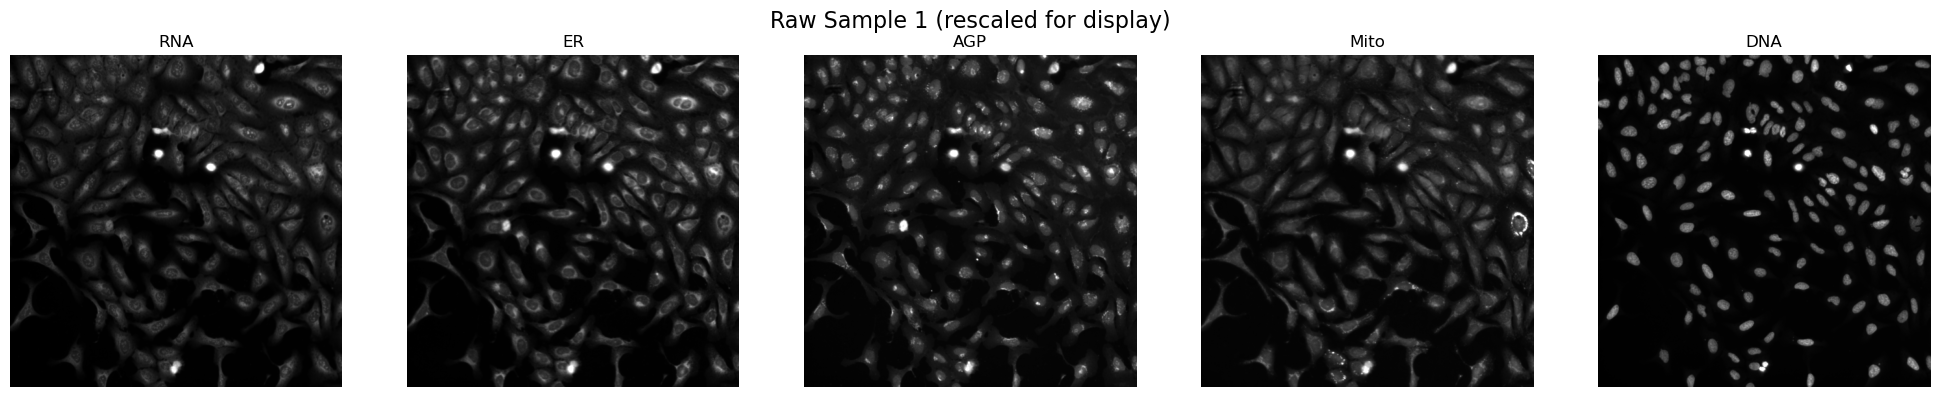

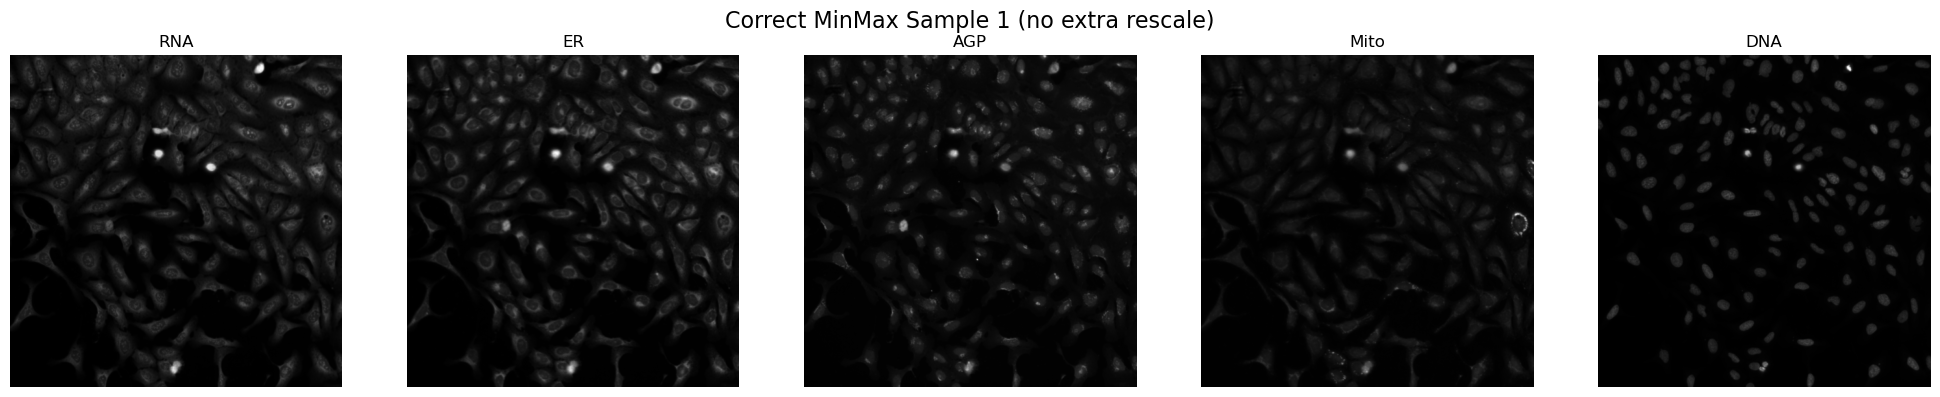

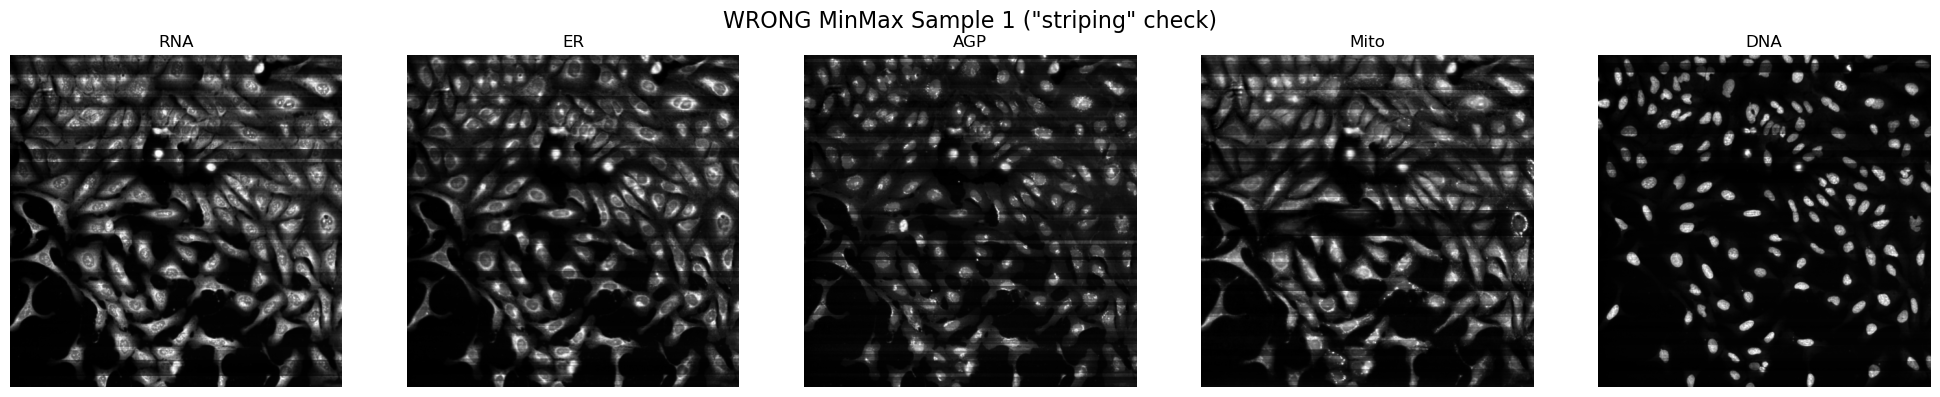


=== Sample 2 === shape (5, 512, 512), dtype float32


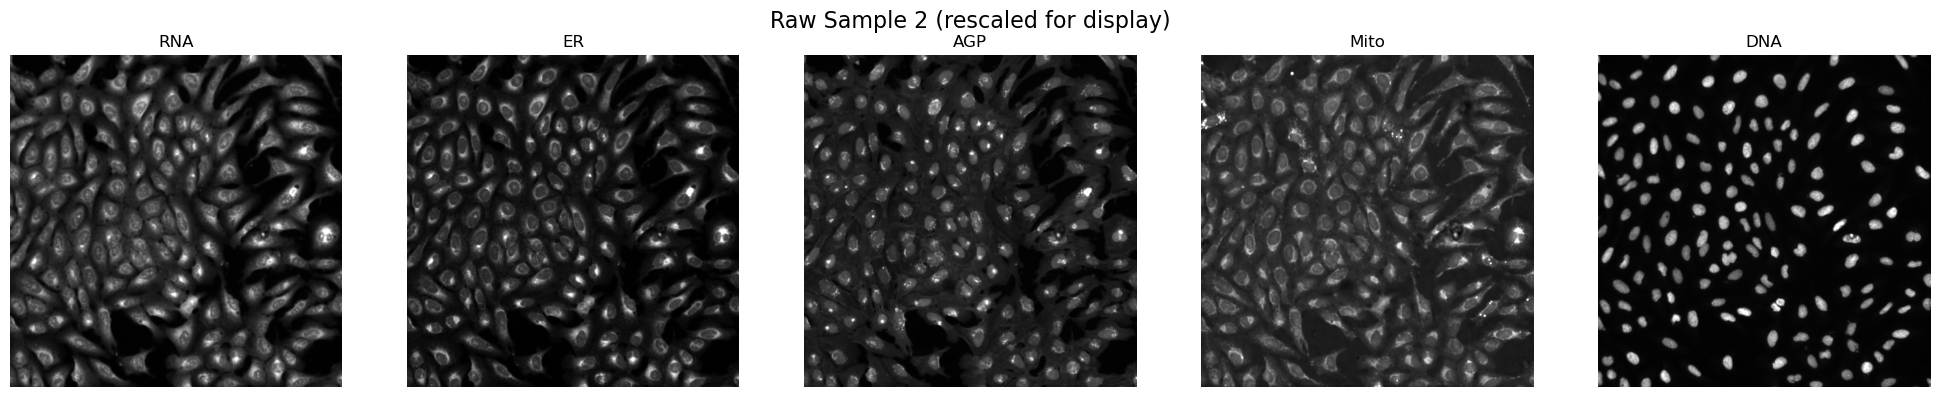

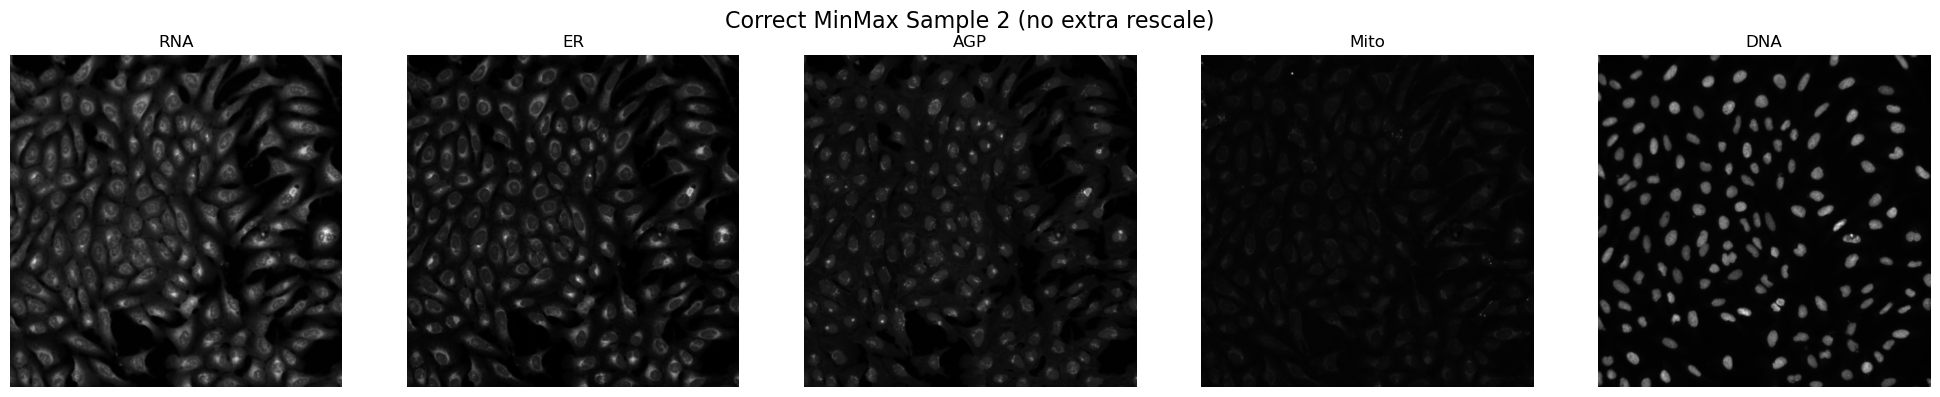

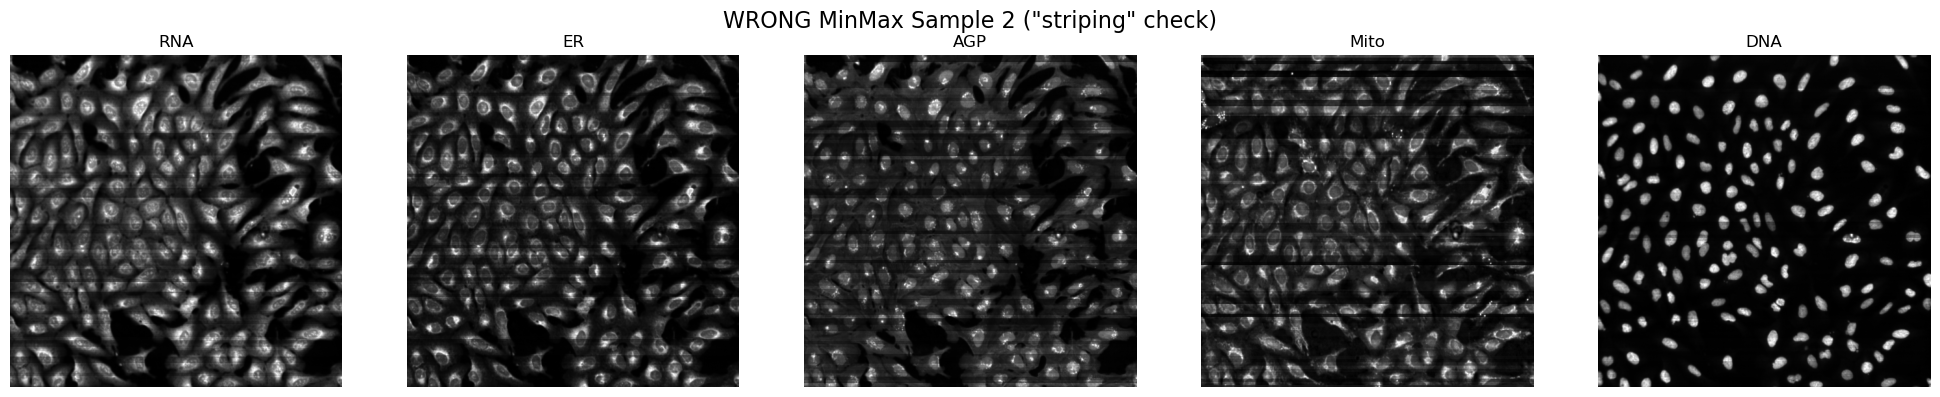


=== Sample 3 === shape (5, 512, 512), dtype float32


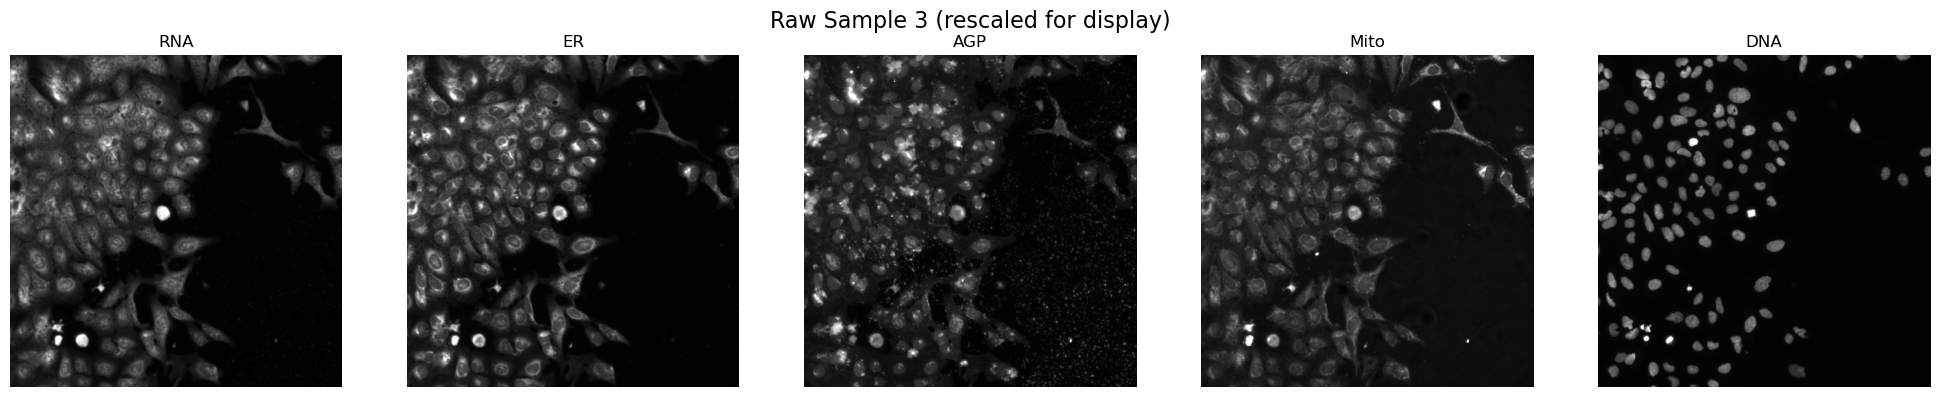

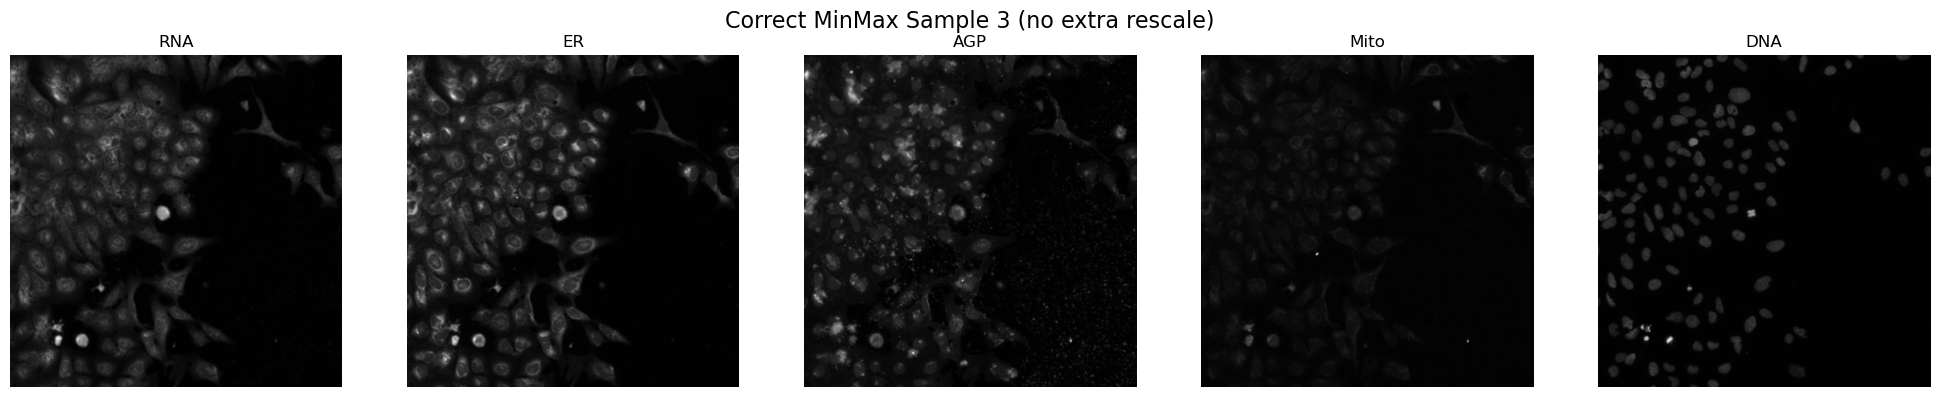

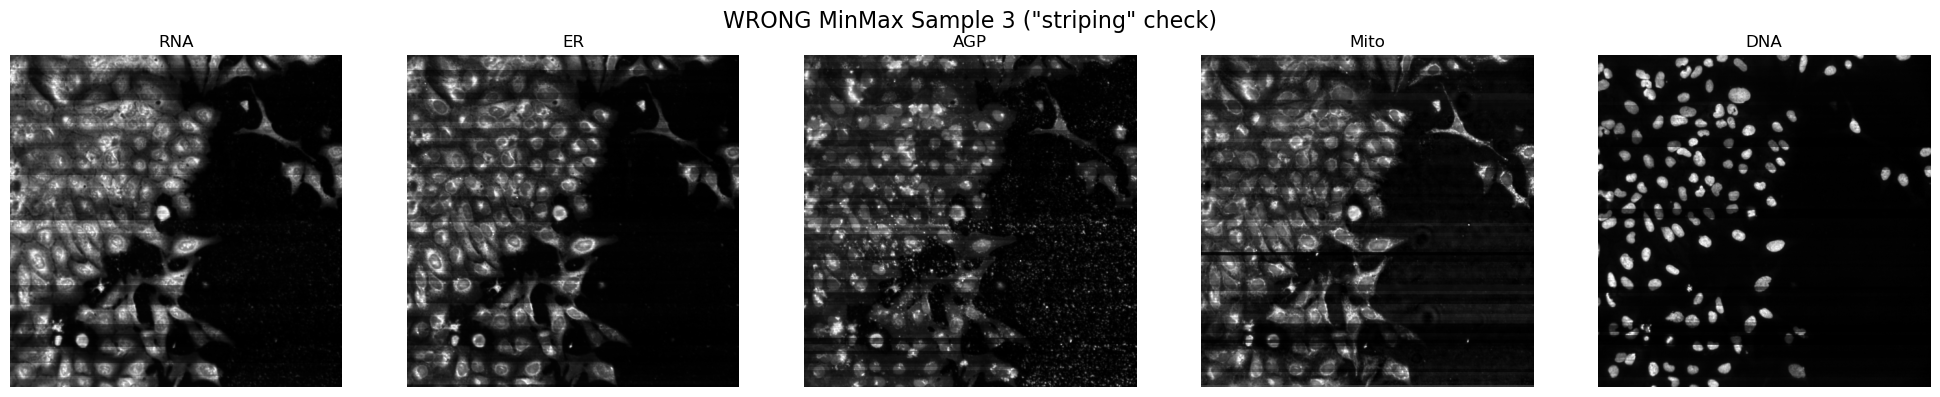


=== Sample 4 === shape (5, 512, 512), dtype float32


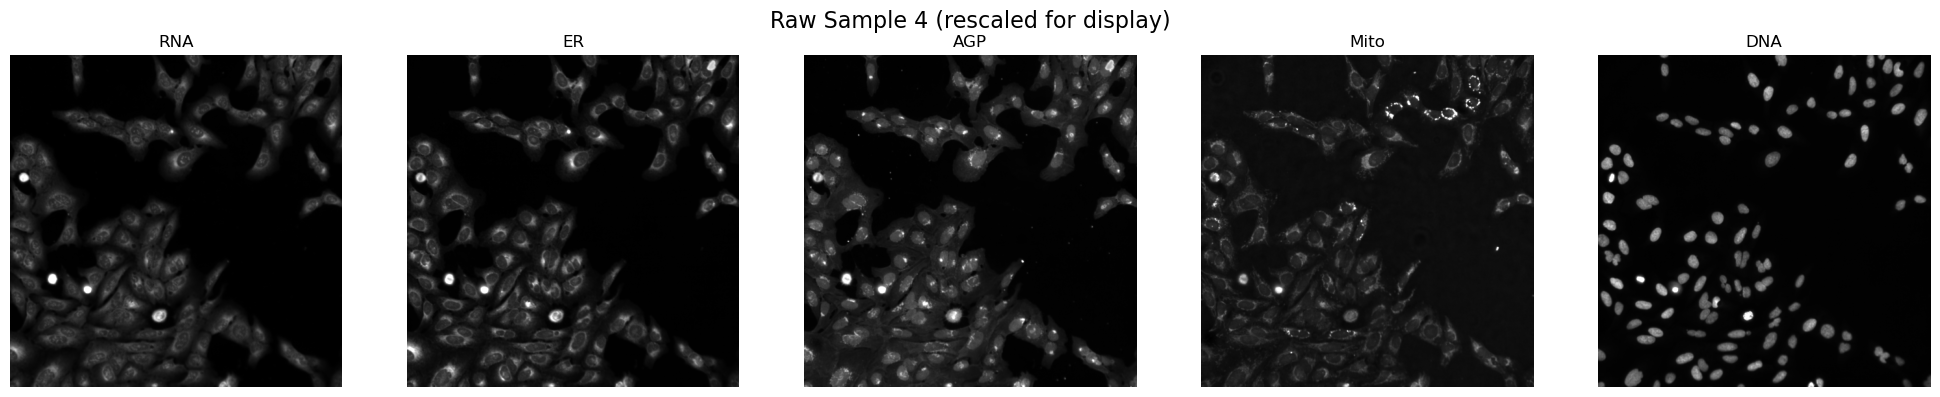

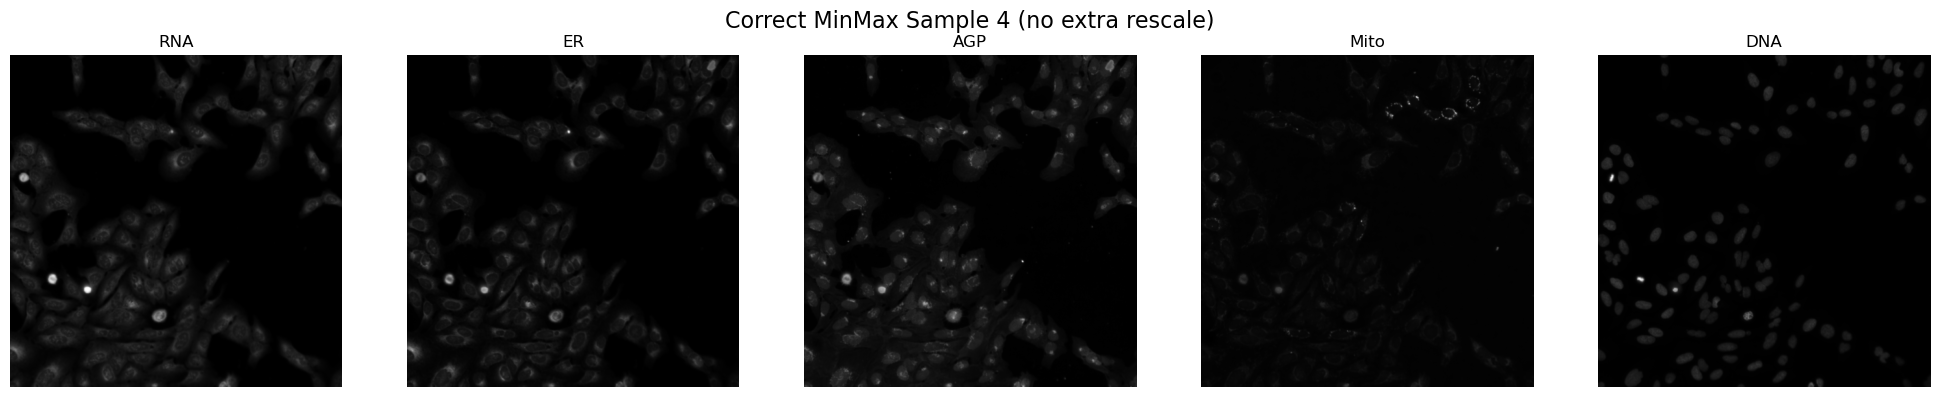

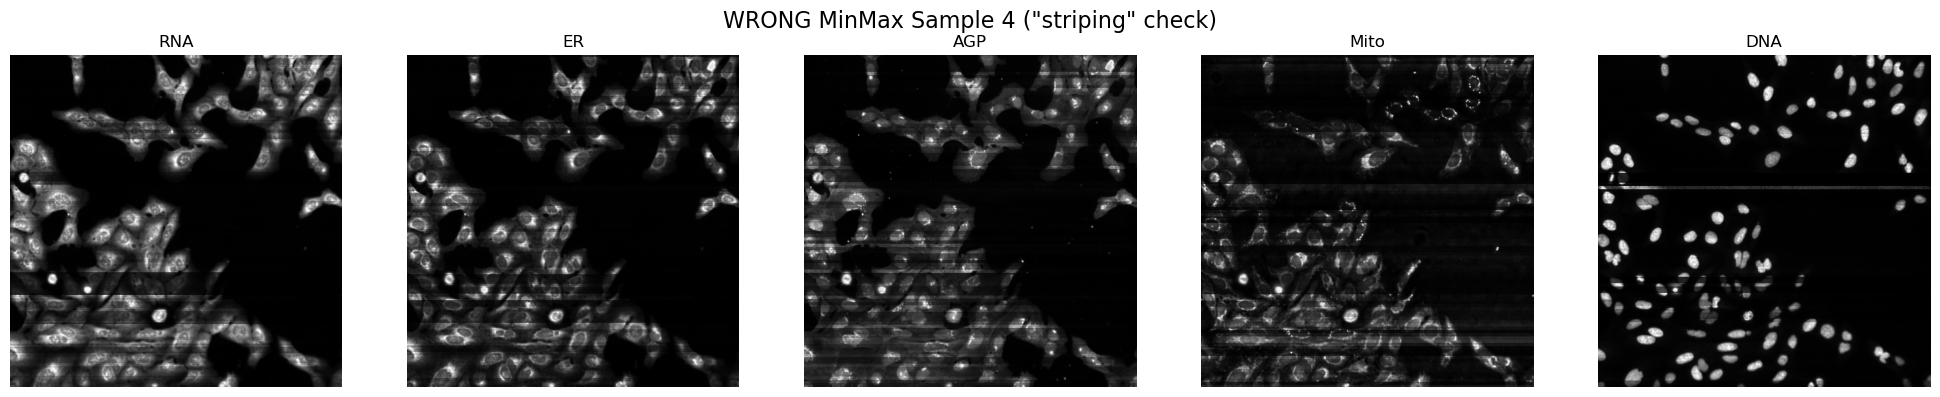


=== Sample 5 === shape (5, 512, 512), dtype float32


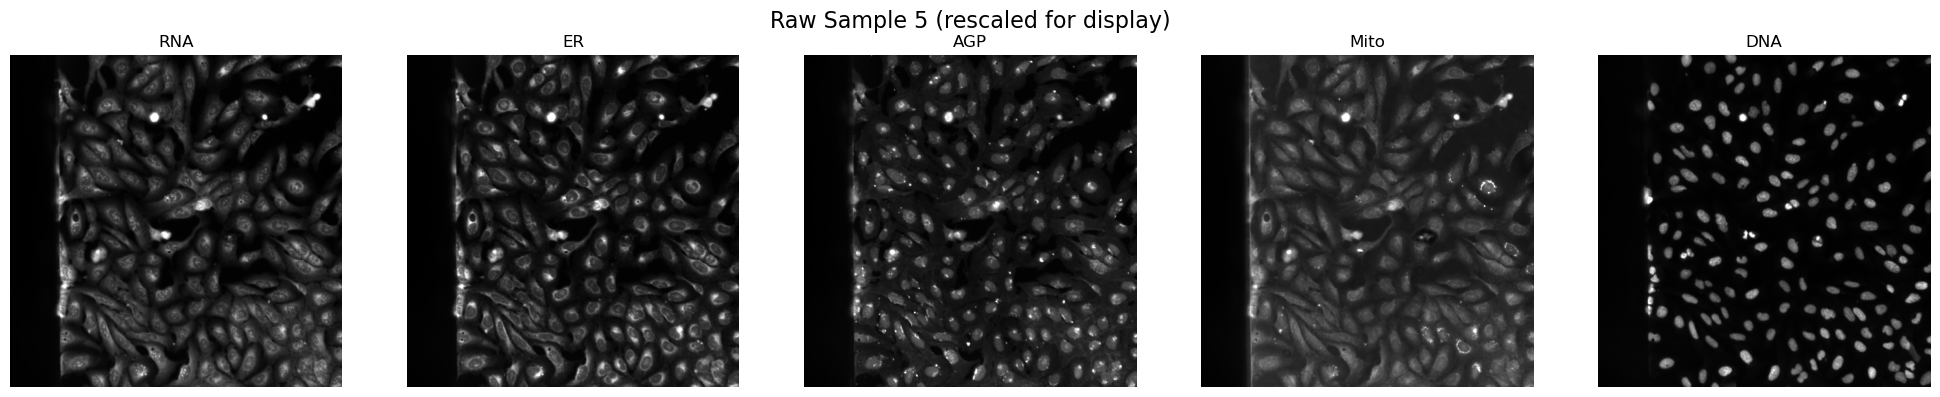

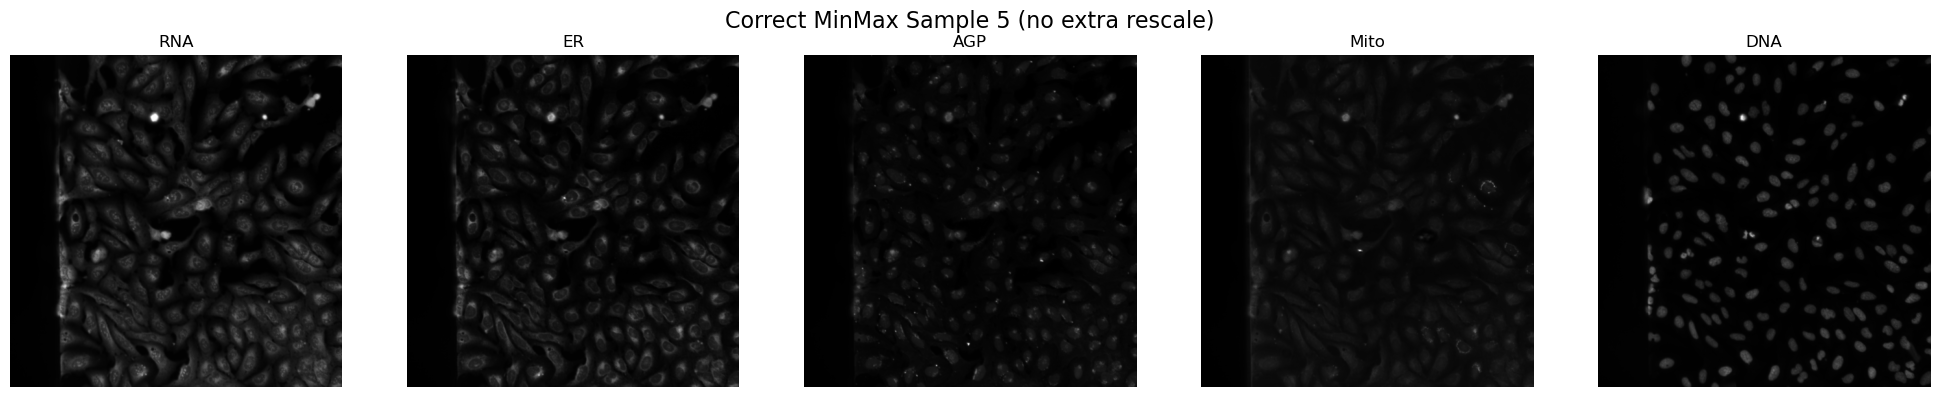

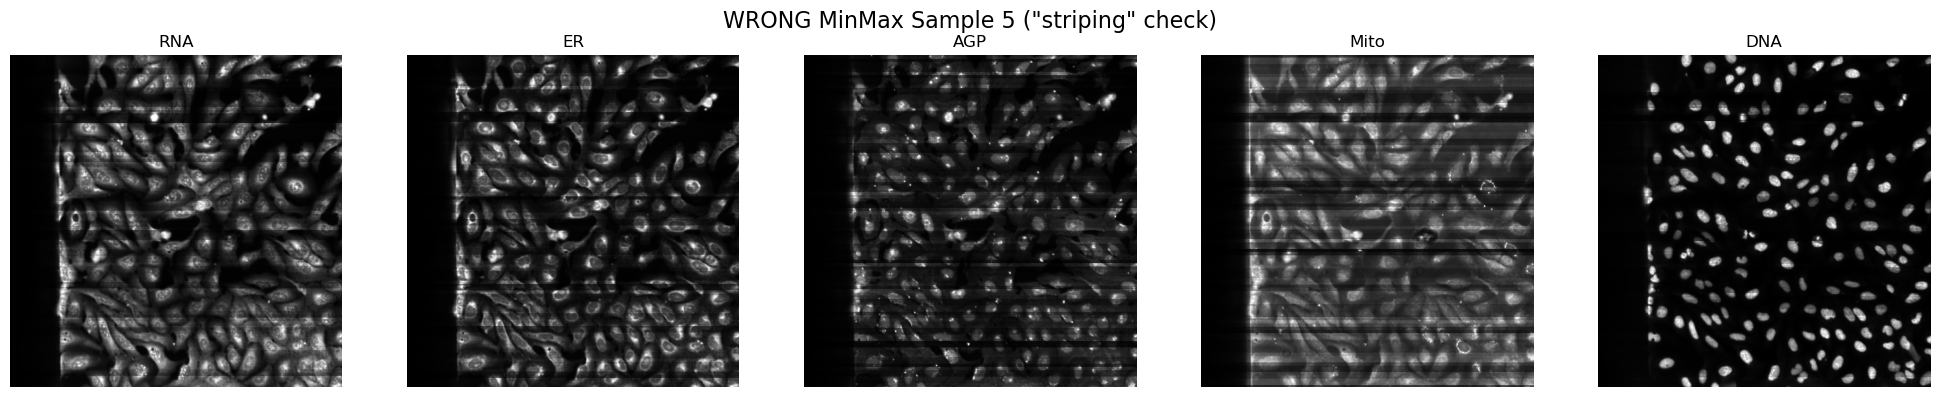

Done! Compare the 'WRONG' version carefully for banding/stripes.


In [2]:
# 04-viz.ipynb

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import webdataset as wds

###########################################
# 1) Basic Setup
###########################################
subset_name = "0.0001"  # or "0.01", etc.
split_name = "train"
base_path = "../../data"

tars_path = os.path.join(base_path, f"jump_{subset_name}", split_name)
tar_files = sorted(glob.glob(os.path.join(tars_path, "*.tar")))
print(f"Found {len(tar_files)} tar files in {tars_path}")
for tf in tar_files[:5]:
    print("  ", tf)

if not tar_files:
    raise ValueError(f"No .tar files found in {tars_path}")

###########################################
# 2) WebDataset Pipeline
###########################################
# We'll just decode the "image.npy" and retrieve it as a NumPy array
dataset = (
    wds.WebDataset(tar_files)
    .shuffle(1000)
    .decode()  # interpret "image.npy" as a NumPy array (if that's how it was saved)
    .to_tuple("image.npy")  # yield (arr,) each iteration
)

num_samples_to_visualize = 5
samples = []

for sample_idx, sample in enumerate(dataset):
    arr = sample[0]  # shape (C, H, W)
    samples.append(arr)
    if sample_idx >= (num_samples_to_visualize - 1):
        break

print(f"Loaded {len(samples)} samples total.")


###########################################
# 3) Visualization Helpers
###########################################
def show_sample_channels(
    arr, channel_names=None, int_percentile=99.9, rescale=True, title=""
):
    """
    Displays each channel in arr side-by-side in a single row of subplots.
    arr: shape (C, H, W)
    channel_names: e.g. ["RNA", "ER", "AGP", "Mito", "DNA"]
    int_percentile: percentile for intensity clipping (for display only)
    rescale: if True, we do a percentile-based scaling to [0,1] for display
    title: optional figure title
    """
    if channel_names is None:
        channel_names = [f"Ch{i}" for i in range(arr.shape[0])]

    c, h, w = arr.shape
    fig, axes = plt.subplots(1, c, figsize=(4 * c, 4))
    if c == 1:
        axes = [axes]

    for i in range(c):
        ax = axes[i]
        if rescale:
            vmax = np.percentile(arr[i], int_percentile)
            vmax = max(vmax, 1e-6)
            img_scaled = np.clip(arr[i] / vmax, 0, 1)
            ax.imshow(img_scaled, cmap="gray")
        else:
            # Show raw values (might look very dark or bright if raw is large)
            ax.imshow(arr[i], cmap="gray")
        ax.set_title(channel_names[i] if i < len(channel_names) else f"Ch{i}")
        ax.axis("off")

    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


###########################################
# 4) Two Versions of Per-Channel Min-Max
###########################################
def minmax_per_channel_correct(arr):
    """
    Correct approach for (C,H,W).
    We do min-max for each channel i in [0..C-1]
    without reshaping, or by carefully reshaping
    (C, H*W) -> one min/max per channel.

    (x - channel_min) / (channel_max - channel_min)
    """
    reshaped = arr.reshape(arr.shape[0], -1)  # => shape (W, C*H)

    min_vals = reshaped.min(axis=1, keepdims=True)
    max_vals = reshaped.max(axis=1, keepdims=True)

    # Each row in W dimension is forced to [0,1]
    # instead of each channel in C dimension
    normed = (reshaped - min_vals) / (max_vals - min_vals + 1e-8)
    normed = normed.reshape(arr.shape)
    return normed.astype(np.float32)


def minmax_per_channel_wrongdim(arr):
    """
    WRONG approach that reshapes (C,H,W) into (W, C*H)
    then does min-max along dim=1. This leads to horizontal
    stripes because you're normalizing rows of width instead
    of actual channels.
    """
    # BAD reshape => (W, C*H)
    # If arr.shape is (C,H,W), then arr.shape[-1] is W
    reshaped = arr.reshape(arr.shape[-1], -1)  # => shape (W, C*H)

    min_vals = reshaped.min(axis=1, keepdims=True)
    max_vals = reshaped.max(axis=1, keepdims=True)

    # Each row in W dimension is forced to [0,1]
    # instead of each channel in C dimension
    normed = (reshaped - min_vals) / (max_vals - min_vals + 1e-8)
    normed = normed.reshape(arr.shape)
    return normed.astype(np.float32)


###########################################
# 5) Show Raw + Compare "correct" vs "wrong"
###########################################
channel_names = ["RNA", "ER", "AGP", "Mito", "DNA"]  # adjust if you have 5 channels

for idx, arr in enumerate(samples):
    print(f"\n=== Sample {idx+1} === shape {arr.shape}, dtype {arr.dtype}")

    # 5A) Show raw
    show_sample_channels(
        arr,
        channel_names=channel_names,
        int_percentile=99.9,
        rescale=True,
        title=f"Raw Sample {idx+1} (rescaled for display)",
    )

    # 5B) Correct min-max
    arr_correct = minmax_per_channel_correct(arr)
    show_sample_channels(
        arr_correct,
        channel_names=channel_names,
        rescale=False,
        title=f"Correct MinMax Sample {idx+1} (no extra rescale)",
    )

    # 5C) Wrong min-max
    arr_wrong = minmax_per_channel_wrongdim(arr)
    show_sample_channels(
        arr_wrong,
        channel_names=channel_names,
        rescale=False,
        title=f'WRONG MinMax Sample {idx+1} ("striping" check)',
    )

print("Done! Compare the 'WRONG' version carefully for banding/stripes.")